### In this notebook, we focus on understanding the differences between datasets openml-train, college, and poverty. It feels like poverty, which is much larger, works better as training data, but it doesn't really follow our data generation methodology.

In [1]:
import pandas as pd

In [25]:
openml_train = pd.read_csv('training-simplified-data-generation.csv')
openml_train['class'] = ['successful' if row['gain_in_r2_score'] > 0 else 'unsuccessful' for index, row in openml_train.iterrows()]

openml_test = pd.read_csv('test-simplified-data-generation.csv')
openml_test['class'] = ['successful' if row['gain_in_r2_score'] > 0 else 'unsuccessful' for index, row in openml_test.iterrows()]

college = pd.read_csv('college-debt-records-features-single-column-w-class')
college['class'] = ['successful' if row['gain_in_r2_score'] > 0 else 'unsuccessful' for index, row in college.iterrows()]

poverty = pd.read_csv('poverty-estimation-results-features-and-targets-training.csv')
poverty['class'] = ['successful' if row['gain_in_r2_score'] > 0 else 'unsuccessful' for index, row in poverty.iterrows()]

taxi = pd.read_csv('taxi-vehicle-collision-records-features-single-column-w-class')
taxi['class'] = ['successful' if row['gain_in_r2_score'] > 0 else 'unsuccessful' for index, row in taxi.iterrows()]


#### First, let's see the balance in the number of successful and unsuccessful examples in these datasets.

In [17]:
def check_class_balance(dataset):
    """ This method checks the number of successfull and unsuccessful instances in 
        a given dataset
    """
    succ = dataset.loc[dataset['class'] == 'successful']
    unsucc = dataset.loc[dataset['class'] == 'unsuccessful']
    print('Number of SUCCESSFUL instances', succ.shape[0])
    print('Number of UNSUCCESSFUL instances', unsucc.shape[0])

In [19]:
check_class_balance(openml_train)

('Number of SUCCESSFUL instances', 5707)
('Number of UNSUCCESSFUL instances', 4177)


In [20]:
check_class_balance(openml_test)

('Number of SUCCESSFUL instances', 2496)
('Number of UNSUCCESSFUL instances', 1780)


In [23]:
check_class_balance(college)

('Number of SUCCESSFUL instances', 130)
('Number of UNSUCCESSFUL instances', 973)


In [26]:
check_class_balance(poverty)

('Number of SUCCESSFUL instances', 11526)
('Number of UNSUCCESSFUL instances', 119402)


In [27]:
check_class_balance(taxi)

('Number of SUCCESSFUL instances', 447)
('Number of UNSUCCESSFUL instances', 0)


#### Note that datasets poverty, college, and taxi are particularly unbalanced! Now let's see the results we get for these datasets when training IDA with different data

In [28]:
FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio', 'query_max_skewness', 
            'query_max_kurtosis', 'query_max_unique', 'candidate_num_rows', 'candidate_max_skewness', 
            'candidate_max_kurtosis', 'candidate_max_unique', 'query_target_max_pearson', 'query_target_max_spearman',
            'query_target_max_covariance', 'query_target_max_mutual_info', 'candidate_target_max_pearson', 
            'candidate_target_max_spearman', 'candidate_target_max_covariance', 'candidate_target_max_mutual_info', 
            'containment_fraction'] 

In [29]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

In [34]:
def train_and_test_classifier(training_collection, test_collections):
    """ This method gets data collections in the format {'name': name, 'dataset': dataset}, 
        trains a random forest classifier over training_collection, and tests the learned model 
        over different test_collections
    """
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(training_collection['dataset'][FEATURES], training_collection['dataset']['class'])
    print('Gini importance of every feature when training with', training_collection['name'])
    print(sorted([(feat_name, importance) for feat_name, importance in zip(FEATURES, rf.feature_importances_)],
                key = lambda x: x[1], reverse=True))
    for collection in test_collections:
        preds = rf.predict(collection['dataset'][FEATURES])
        print('Results for collection', collection['name'])
        print(classification_report(collection['dataset']['class'], preds))

In [35]:
training = {'name': 'openml_train', 'dataset': openml_train}
test = [{'name': 'openml_test', 'dataset': openml_test},
        {'name': 'college', 'dataset': college},
        {'name': 'poverty', 'dataset': poverty},
        {'name': 'taxi', 'dataset': taxi}]

train_and_test_classifier(training, test)

('Gini importance of every feature when training with', 'openml_train')
[('candidate_target_max_spearman', 0.085857368237551746), ('candidate_target_max_pearson', 0.084791144189473144), ('candidate_target_max_covariance', 0.068272095809208469), ('query_row_column_ratio', 0.06666023590466745), ('candidate_max_skewness', 0.062633198520323285), ('candidate_max_kurtosis', 0.062020448564194239), ('query_num_of_columns', 0.057576520531146723), ('query_max_kurtosis', 0.056478362140158112), ('query_target_max_spearman', 0.055448186750256784), ('query_target_max_pearson', 0.053931863883894378), ('query_target_max_covariance', 0.052981500751144973), ('query_max_skewness', 0.051155402056557289), ('candidate_target_max_mutual_info', 0.045127776668826593), ('candidate_max_unique', 0.040322995720460976), ('candidate_num_rows', 0.037725516590675336), ('query_max_unique', 0.037094948420186541), ('query_target_max_mutual_info', 0.035659429583705764), ('query_num_of_rows', 0.024103173065734354), ('conta

#### The results show that, when training with openml_train, the results get pretty bad for poverty and college, good for taxi, and good-ish for openml_test.

In [36]:
training = {'name': 'poverty', 'dataset': poverty}
test = [{'name': 'openml_test', 'dataset': openml_test},
        {'name': 'college', 'dataset': college},
        {'name': 'openml_train', 'dataset': openml_train},
        {'name': 'taxi', 'dataset': taxi}]

train_and_test_classifier(training, test)

('Gini importance of every feature when training with', 'poverty')
[('candidate_target_max_spearman', 0.20071414551983074), ('candidate_target_max_mutual_info', 0.18720951769515032), ('candidate_target_max_pearson', 0.16328095128794956), ('candidate_num_rows', 0.11522687918870228), ('containment_fraction', 0.085077581986379811), ('candidate_target_max_covariance', 0.077344635379532886), ('candidate_max_unique', 0.068031969748050064), ('candidate_max_skewness', 0.052219224461296149), ('candidate_max_kurtosis', 0.05089509473310825), ('query_num_of_columns', 0.0), ('query_num_of_rows', 0.0), ('query_row_column_ratio', 0.0), ('query_max_skewness', 0.0), ('query_max_kurtosis', 0.0), ('query_max_unique', 0.0), ('query_target_max_pearson', 0.0), ('query_target_max_spearman', 0.0), ('query_target_max_covariance', 0.0), ('query_target_max_mutual_info', 0.0)]
('Results for collection', 'openml_test')
              precision    recall  f1-score   support

  successful       0.63      0.62      0.

#### Note that the results get better for college and are similar for openml_test. The recall is significantly lower for taxi, though. Note that for poverty the query features don't matter, as they're always the same because of the way the query and candidates were generated. Still, note that the importance of features such as "candidate_target_max_spearman" is much higher than when we train over openml_train, meaning that they discriminate successful and unsuccessful examples better in the poverty dataset.

In [37]:
training = {'name': 'college', 'dataset': college}
test = [{'name': 'openml_test', 'dataset': openml_test},
        {'name': 'poverty', 'dataset': poverty},
        {'name': 'openml_train', 'dataset': openml_train},
        {'name': 'taxi', 'dataset': taxi}]

train_and_test_classifier(training, test)

('Gini importance of every feature when training with', 'college')
[('containment_fraction', 0.25590842571004252), ('candidate_target_max_pearson', 0.16994958421264755), ('candidate_target_max_spearman', 0.16540688323169758), ('candidate_target_max_mutual_info', 0.1613674863739239), ('candidate_num_rows', 0.059830571477167284), ('candidate_target_max_covariance', 0.058827364402313419), ('candidate_max_unique', 0.057579520252289379), ('candidate_max_skewness', 0.036722534431533532), ('candidate_max_kurtosis', 0.034407629908384765), ('query_num_of_columns', 0.0), ('query_num_of_rows', 0.0), ('query_row_column_ratio', 0.0), ('query_max_skewness', 0.0), ('query_max_kurtosis', 0.0), ('query_max_unique', 0.0), ('query_target_max_pearson', 0.0), ('query_target_max_spearman', 0.0), ('query_target_max_covariance', 0.0), ('query_target_max_mutual_info', 0.0)]
('Results for collection', 'openml_test')
              precision    recall  f1-score   support

  successful       0.62      0.66      0.

#### Note that the results are again okay-ish for openml_train and openml_test, but the recall is terrible for poverty and taxi. Basically, when we train over college, the model learns that every augmentation instance in poverty and taxi is 'unsuccessful'.  Moreover, note how feature 'containment_fraction' is super important for college, which is not the case for poverty or openml_train. 

#### Let's check the feature distributions for these different collections, KEEPING IN MIND THAT QUERY FEATURES ARE NOT USED BY MODELS BUILT OVER DATASETS COLLEGE OR POVERTY.

In [93]:
OUTLIER_THRESHOLD_MAD = 3
def remove_outliers_based_on_mad(feature):
  mad = feature.mad() #median_absolute_deviation(feature)
  median = np.median(feature)
  return [i for i in feature if np.fabs((i - median)/mad) < OUTLIER_THRESHOLD_MAD]


def plot_two_kinds_of_histograms(data1, label1, data2, label2):
  """ This function plots histograms for features and targets, just like                                                                                                          
  function 'plot_features_and_target_histograms' for two different data (data1 and data2)                                                                                         
  """
  for feature_name in FEATURES:                                                                                                                        
    tmp1 = remove_outliers_based_on_mad(data1[feature_name])                                                                                                 
    tmp2 = remove_outliers_based_on_mad(data2[feature_name])                                                                                                 
    plt.hist(tmp1, bins=50, alpha=0.7, label=label1, color='blue')
    plt.hist(tmp2, bins=50, alpha=0.7, label=label2, color='red')
    plt.xlabel('Value Ranges')
    plt.ylabel('Percentages')
    plt.title(feature_name)                                                                                                         
    plt.legend()
    plt.show() 
    #plt.close()

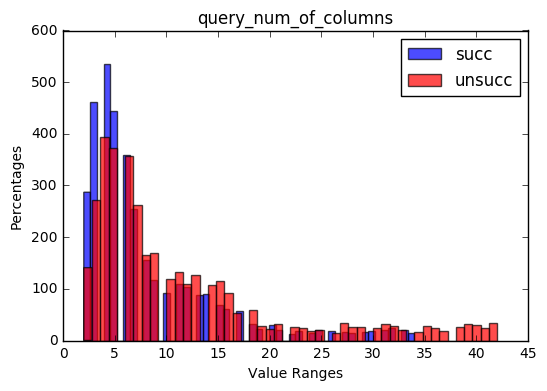

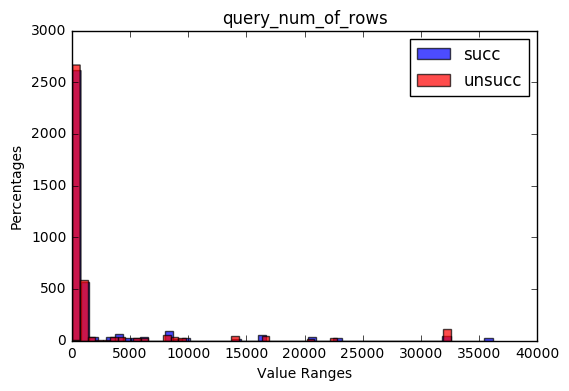

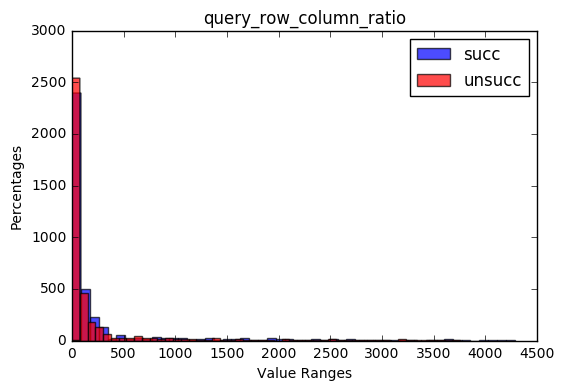

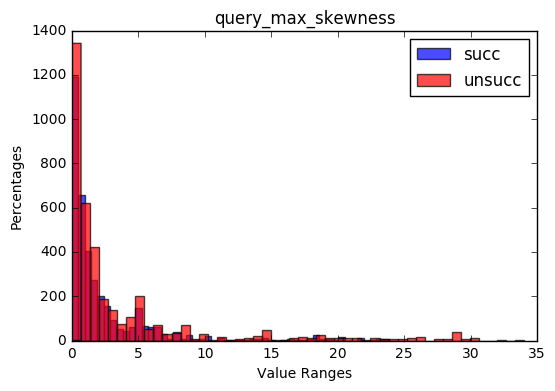

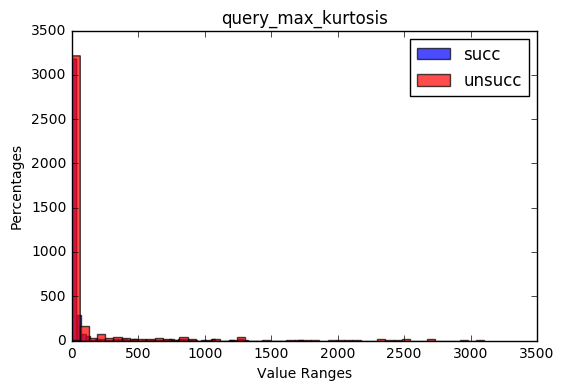

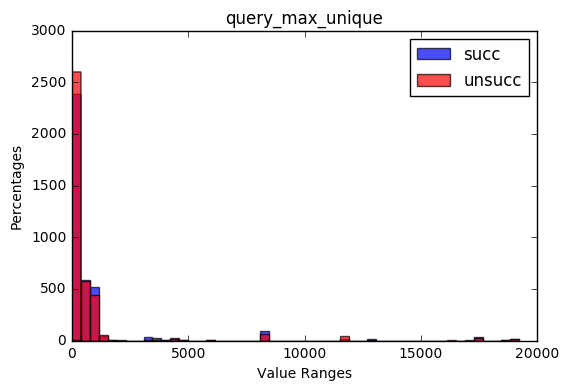

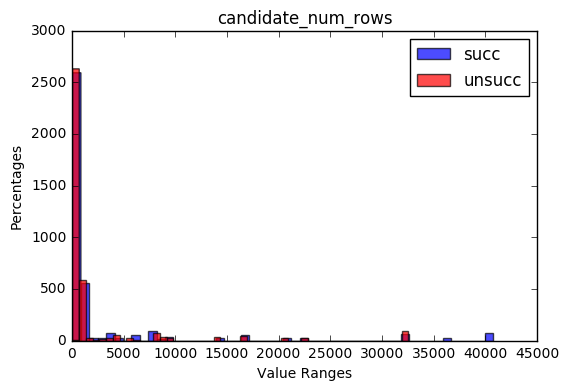

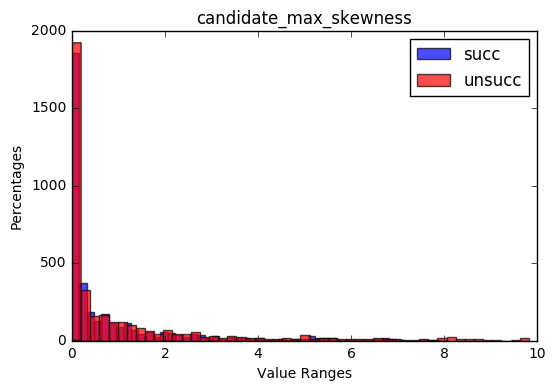

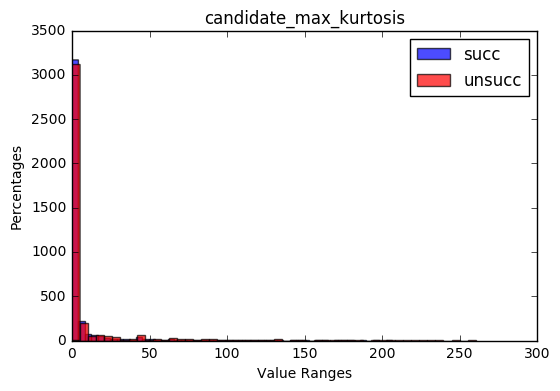

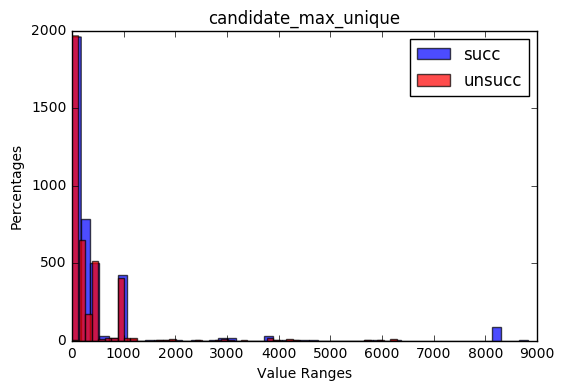

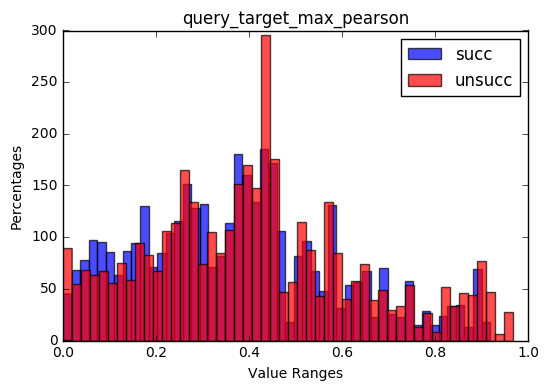

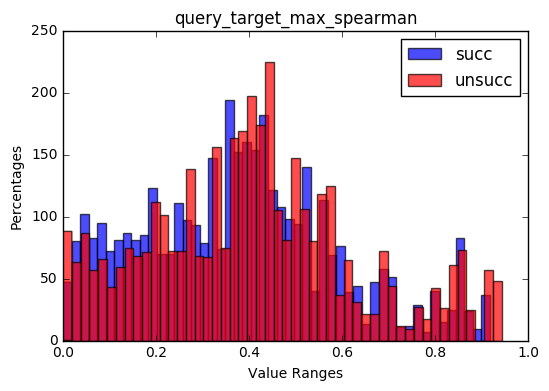

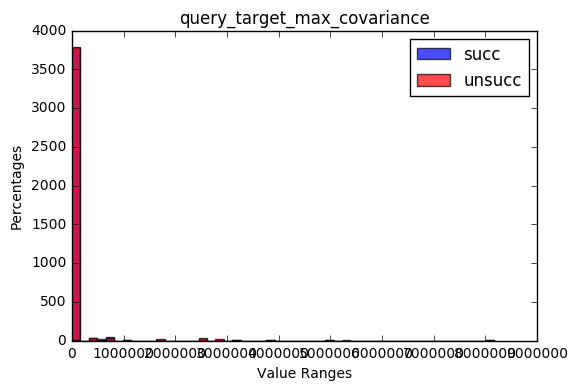

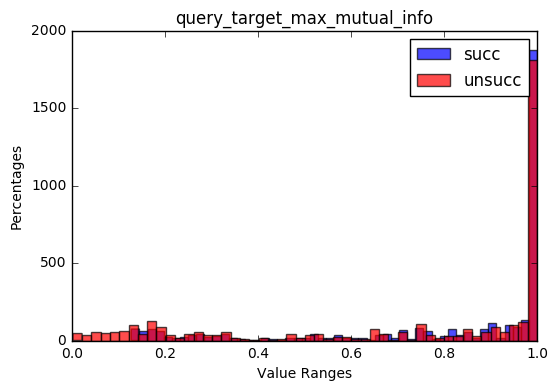

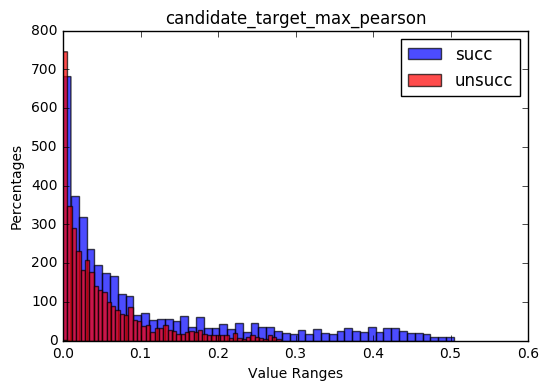

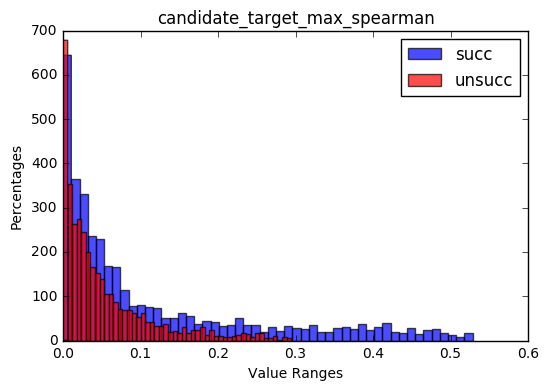

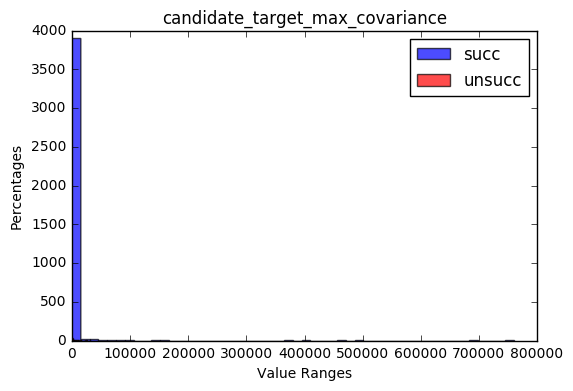

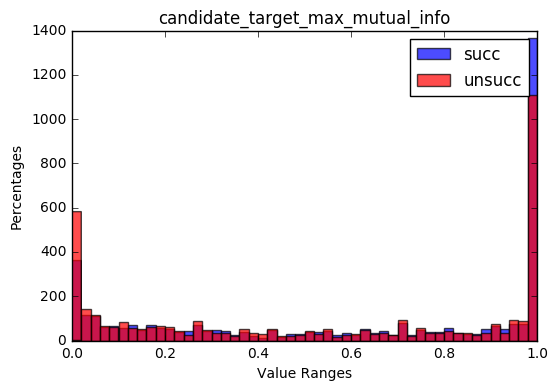

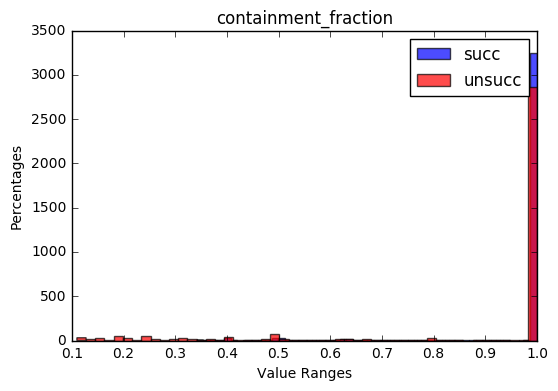

In [94]:
#sampling due to imbalance
succ = openml_train.loc[openml_train['class'] == 'successful'].sample(n=4000)
unsucc = openml_train.loc[openml_train['class'] == 'unsuccessful'].sample(n=4000)
plot_two_kinds_of_histograms(succ, 'succ', unsucc, 'unsucc')

#### Let's see how features behave for poverty.

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


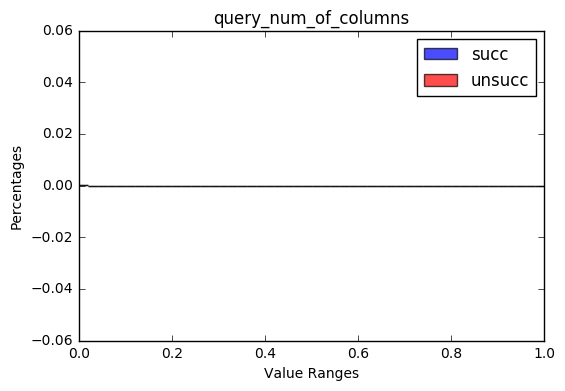

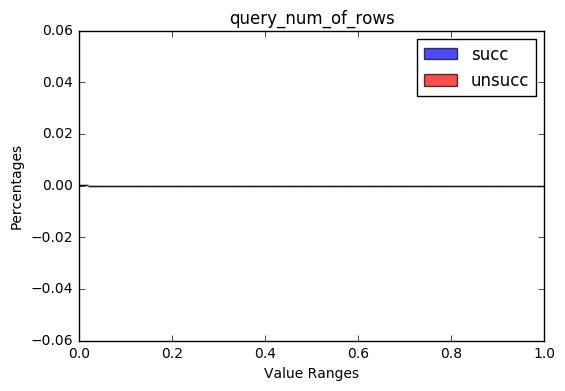

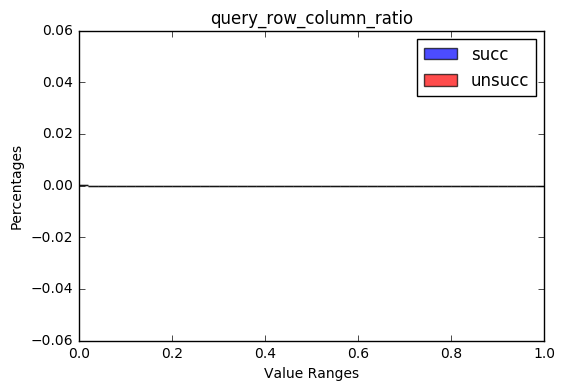

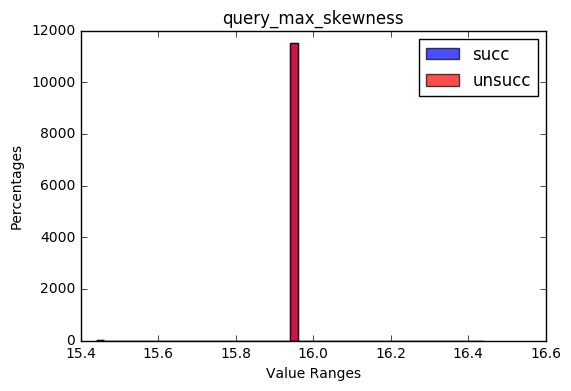

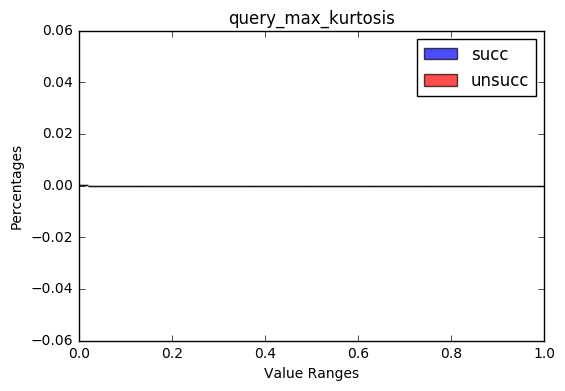

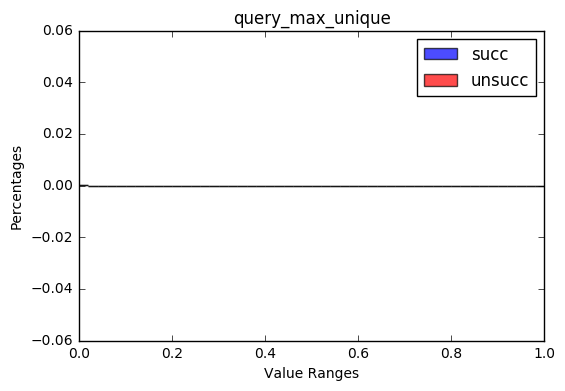

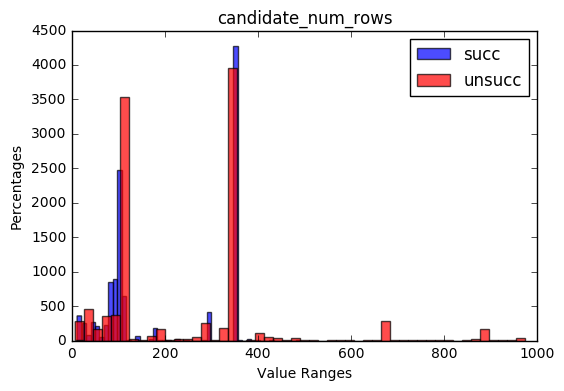

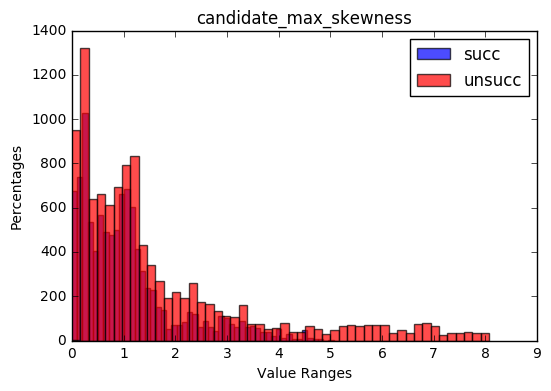

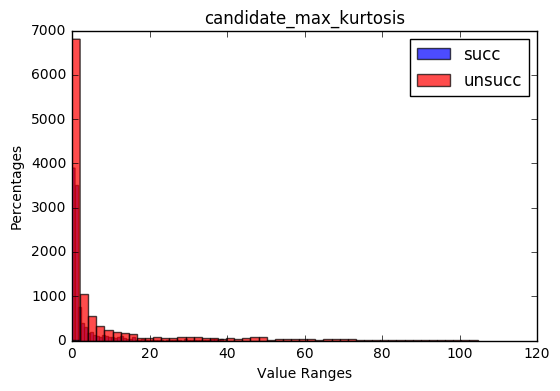

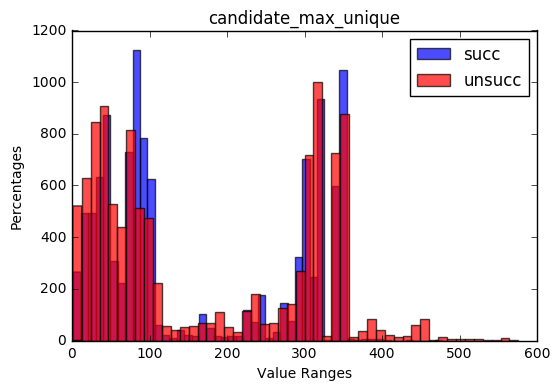

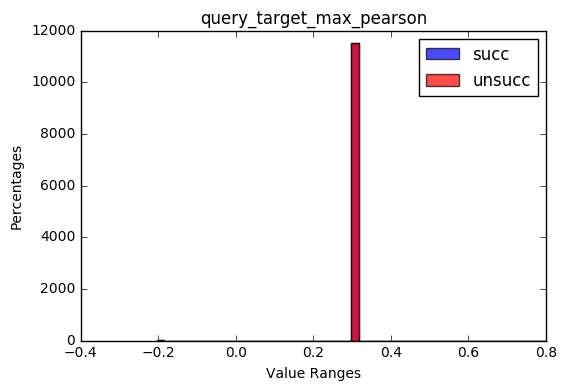

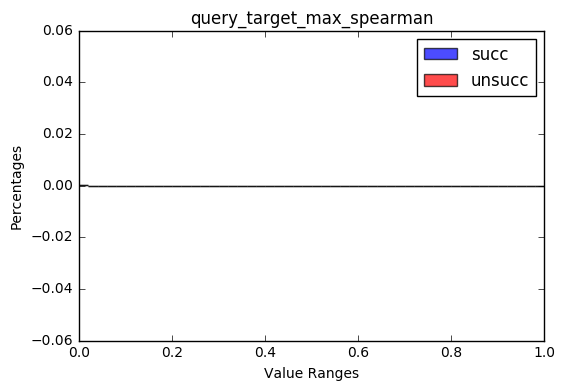

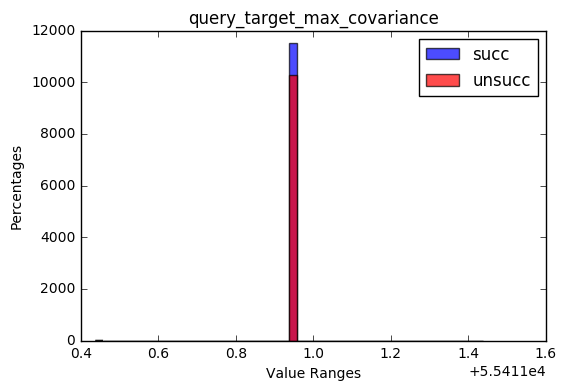

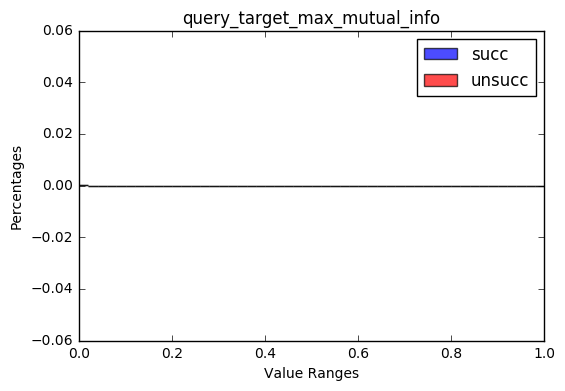

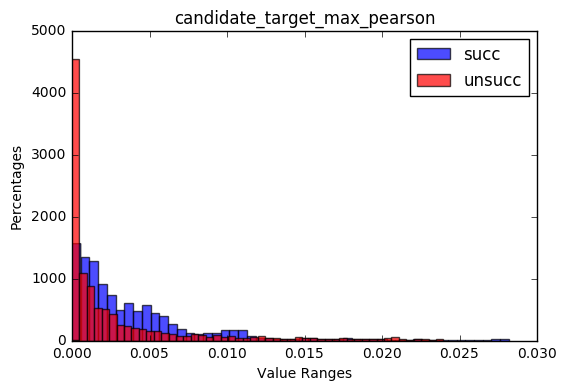

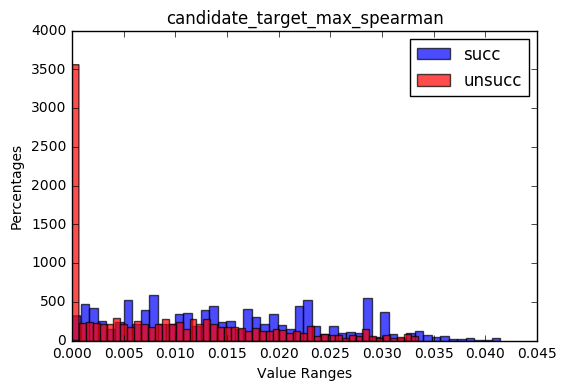

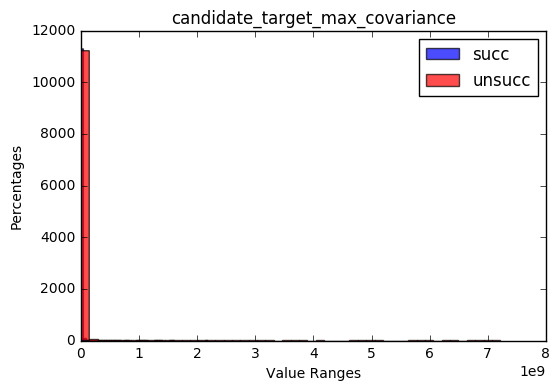

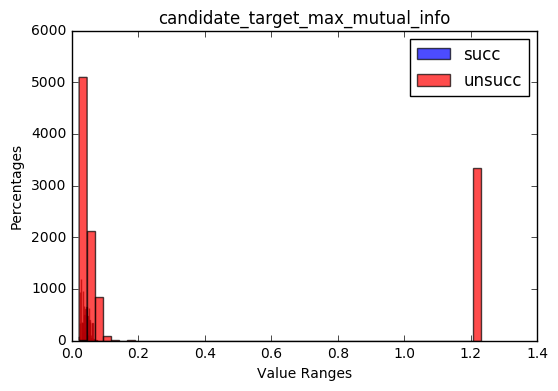

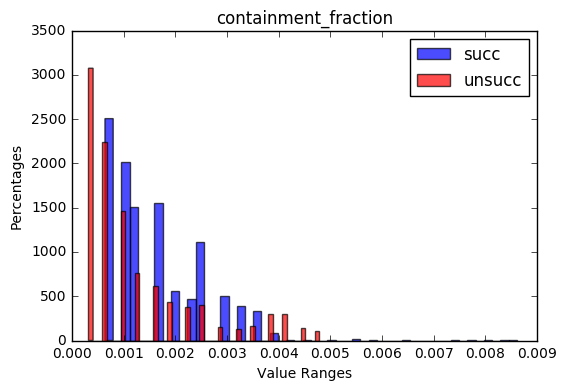

In [95]:
#sampling due to imbalance
succ = poverty.loc[poverty['class'] == 'successful'].sample(n=11500)
unsucc = poverty.loc[poverty['class'] == 'unsuccessful'].sample(n=11500)
plot_two_kinds_of_histograms(succ, 'succ', unsucc, 'unsucc')

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


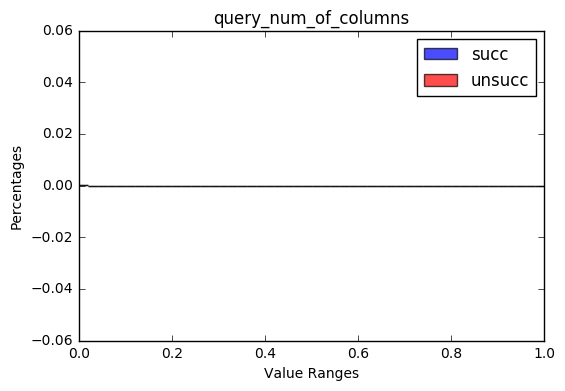

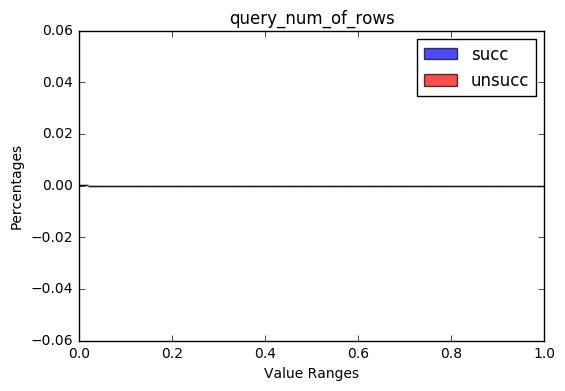

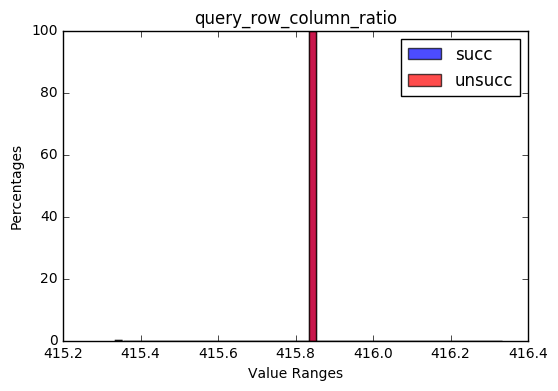

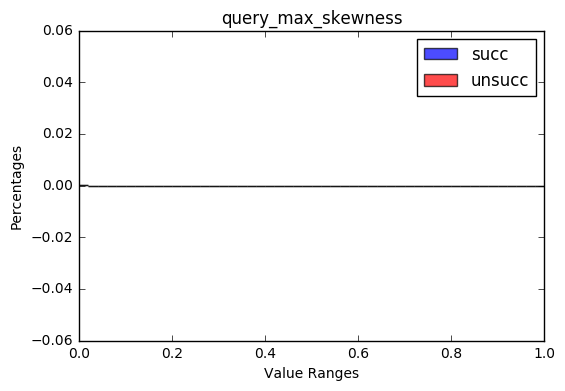

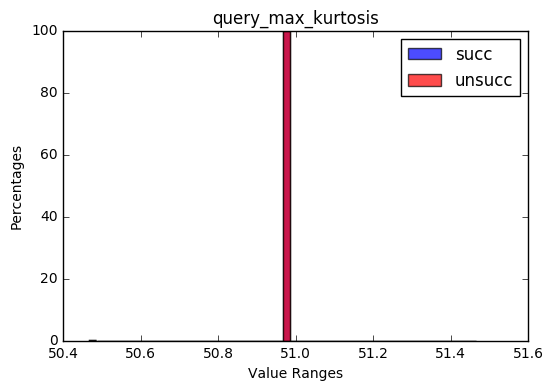

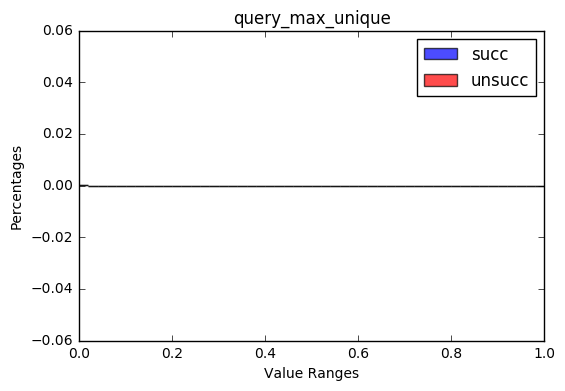

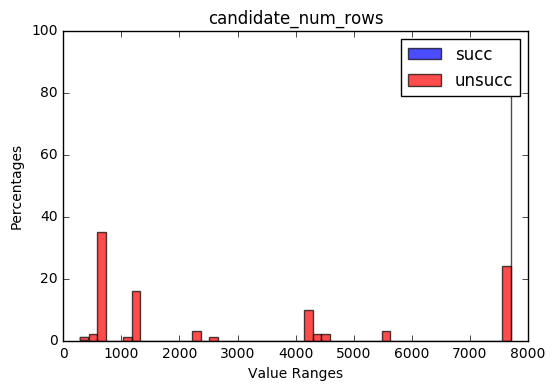

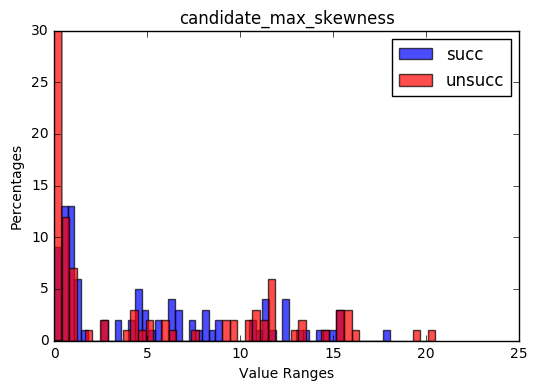

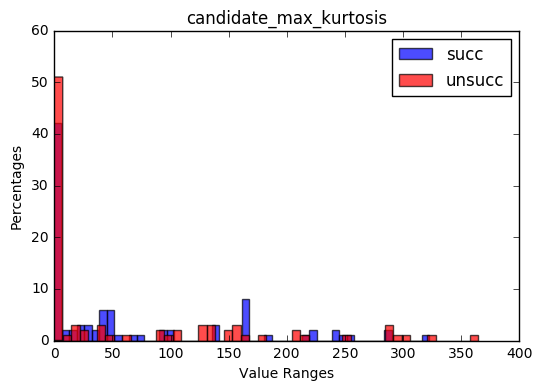

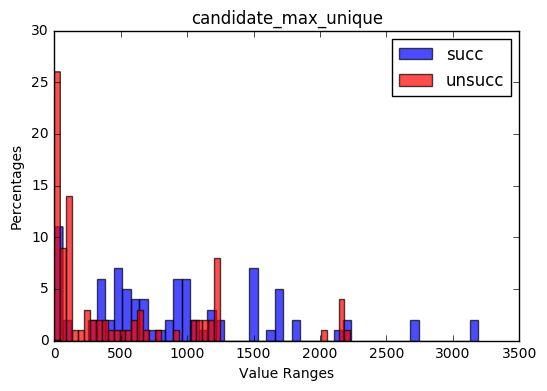

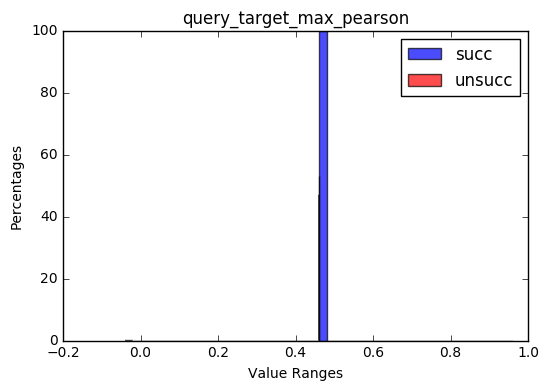

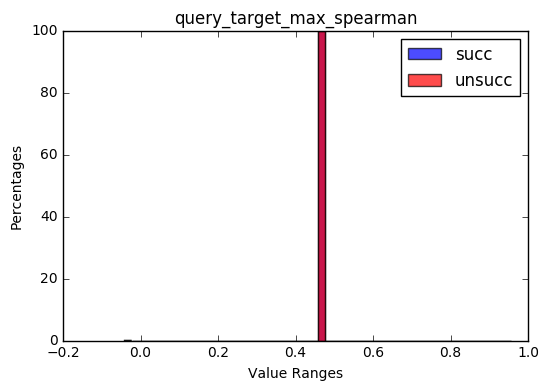

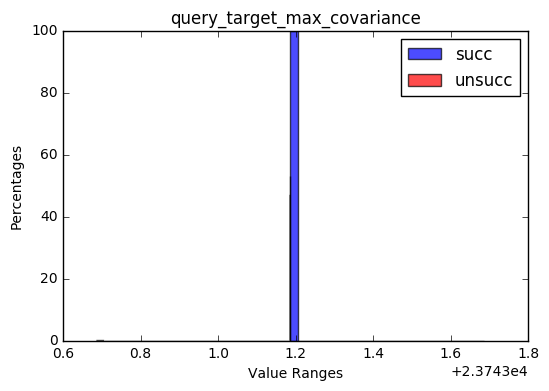

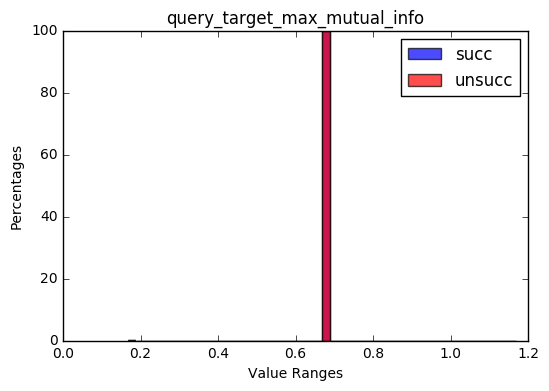

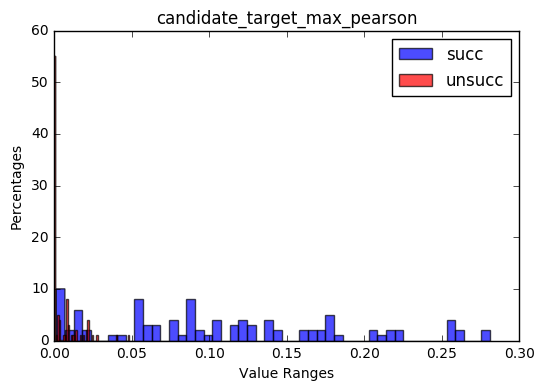

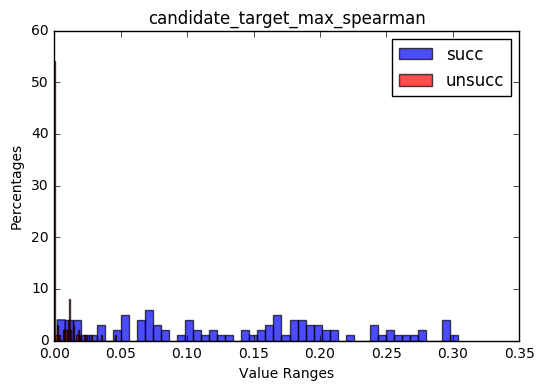

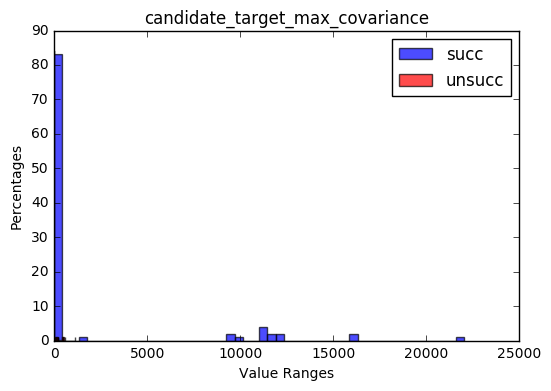

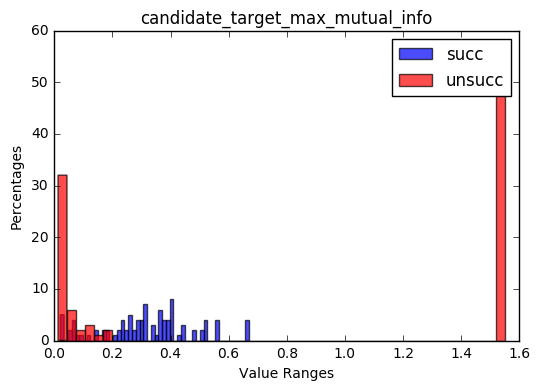

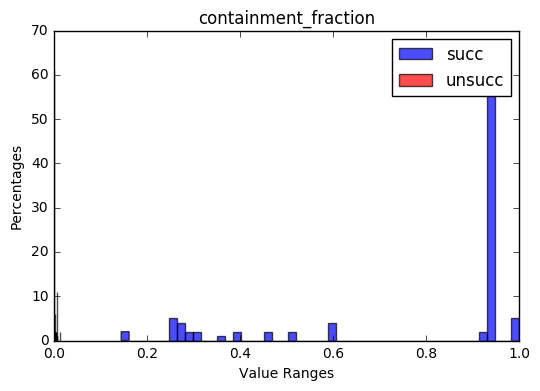

In [96]:
#sampling due to imbalance
succ = college.loc[college['class'] == 'successful'].sample(n=100)
unsucc = college.loc[college['class'] == 'unsuccessful'].sample(n=100)
plot_two_kinds_of_histograms(succ, 'succ', unsucc, 'unsucc')

#### It is interesting to notice that candidate_target_max_spearman separates succ from unsucc much more clearly for college. Note that even the highest spearman values (WE ARE USING SAMPLES AND REMOVED OUTLIERS) for poverty are extremely low... For a huge number of unsuccessful cases, the candidate_target_max_spearman is zero, or very very close to zero ---- maybe that's why this feature has a high-ish Gini importance. 

#### TO INVESTIGATE: Do I even need query features at all? 

#### TO INVESTIGATE: What if the training data is "very clean", i.e., no overlap for candidate_target_max_spearman, and possibly for a few other features?


#### Now let's do another inspection, by checking a few college instances that are correctly classified when we train with poverty, and incorrectly classified when we train our model over openml-train. 

#### Then we can repeat the process for taxi and openml-test.

In [97]:
import eli5
rf_openml_train = RandomForestClassifier(n_estimators=100, random_state=42)
rf_openml_train.fit(openml_train[FEATURES], openml_train['class'])
rf_poverty = RandomForestClassifier(n_estimators=100, random_state=42)
rf_poverty.fit(poverty[FEATURES], poverty['class'])

college_preds_openml_train = rf_openml_train.predict(college[FEATURES])
college_preds_poverty = rf_poverty.predict(college[FEATURES])
college['college_preds_openml_train'] = college_preds_openml_train
college['college_preds_poverty'] = college_preds_poverty

false_positive_openml_train = college.loc[(college['class'] == 'unsuccessful') & 
                                          (college['college_preds_openml_train'] == 'successful')]
false_negative_openml_train = college.loc[(college['class'] == 'successful') & 
                                          (college['college_preds_openml_train'] == 'unsuccessful')]
false_positive_poverty = college.loc[(college['class'] == 'unsuccessful') & 
                                          (college['college_preds_poverty'] == 'successful')]
false_negative_poverty = college.loc[(college['class'] == 'successful') & 
                                          (college['college_preds_poverty'] == 'unsuccessful')]


#true_positive = college.loc[(college['class'] == 1) & (college['pred'] == 1)]
#true_negative = college.loc[(college['class'] == -1) & (college['pred'] == -1)]

In [99]:
sample_fp_openml_train = false_positive_openml_train.sample(5)
sample_fn_openml_train = false_negative_openml_train.sample(5)

sample_fp_poverty = false_positive_poverty.sample(5)
sample_fn_poverty = false_negative_poverty.sample(5)